In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# import plotly as py
# import plotly.graph_objs as go
import os

#print(os.listdir("../input"))
import datetime as dt
import missingno as msno

plt.rcParams['figure.dpi'] = 140

In [22]:
style_params = {
    'patch.edgecolor': 'none',
    'font.family': 'sans-serif',
    'font.weight': 'light',
    'font.size': 8,
    'ytick.labelsize': 6,
    'figure.facecolor': '#fafafa',
    'axes.facecolor': '#fafafa',
    'axes.linewidth': 0.3

}
plt.rcParams.update(style_params)

# Data

In [3]:
url = "https://raw.githubusercontent.com/allenkong221/netflix-titles-dataset/main/netflix_titles.csv"
df = pd.read_csv(url)
# Quick feature engineering

# Helper column for various plots
df['count'] = 1

# Many productions have several countries listed - this will skew our results , we'll grab the first one mentioned

# Lets retrieve just the first country
df['first_country'] = df['country'].apply(lambda x: x.split(", ")[0] if isinstance(x, str) else x)
df['first_country'].head()

# Rating ages from this notebook: https://www.kaggle.com/andreshg/eda-beginner-to-expert-plotly (thank you!)

ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

# Genre

df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 

# Reducing name length

df['first_country'].replace('United States', 'USA', inplace=True)
df['first_country'].replace('United Kingdom', 'UK',inplace=True)
df['first_country'].replace('South Korea', 'S. Korea',inplace=True)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,count,first_country,target_ages,genre
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,1,USA,Older Kids,"[Children & Family Movies, Comedies]"
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,1,UK,Adults,[Stand-Up Comedy]
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",1,USA,Older Kids,[Kids' TV]
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,1,USA,Older Kids,[Kids' TV]
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,1,USA,Teens,[Comedies]


# Barplot

In [4]:
data = df.groupby('first_country')['count'].sum().sort_values(ascending=False)[:10]

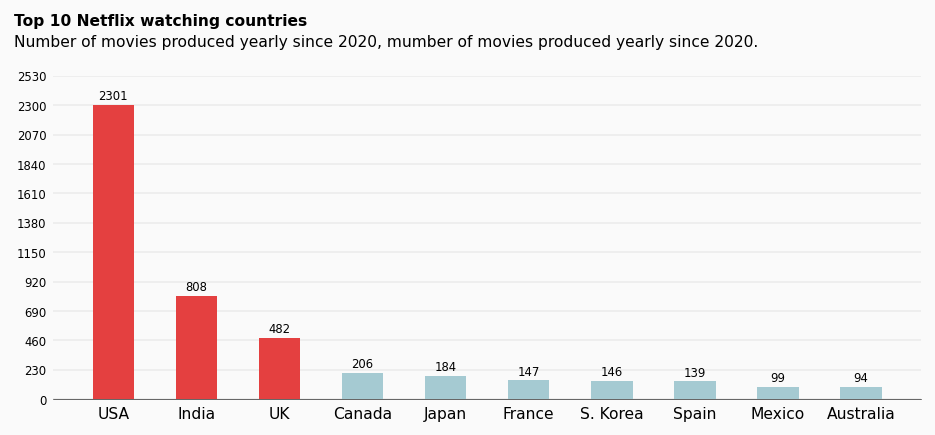

In [44]:
def simple_barplot(
    data, 
    title,
    title_text,
    top_k=3, 
    colormap=['#e44040','#d05039', '#b35f34', '#dfa75b', '#a5cad2']
    ):
    n_samples = data.shape[0]
    y_max = np.max(data)
    
    data = data.sort_values(ascending=False)

    colormap_ = [colormap[4] for _ in range(n_samples)]
    for k in range(top_k):
        colormap_[k] = colormap[0] # color highlight

    # Bar plot
    fig, ax = plt.subplots(1,1, figsize=(8,3))
    ax.bar(
        data.index, 
        data, 
        width=0.5, 
        color=colormap_
    )
    for i in data.index:
        ax.annotate(
            f"{data[i]}", 
            xy=(i, data[i] + y_max * 0.03), 
            va = 'center', 
            ha='center',
            fontsize=style_params['ytick.labelsize']
    )


    # Remove border from plot
    for s in ['top', 'left', 'right']:
        ax.spines[s].set_visible(False)
        
    # Tick labels
    ax.set_xticklabels(data.index, rotation=0)

    # Title and sub-title
    fig.text(0.09, 1, title, fontweight='bold')
    fig.text(0.09, 0.95, title_text)
    #fig.text(1.1, 1.01, 'Insight', fontweight='bold')

    # fig.text(1.1, 0.67, '''
    # The most prolific producers of
    # content for Netflix are, primarily,
    # the USA, with India and the UK
    # a significant distance behind.

    # It makes sense that the USA produces 
    # the most content as, afterall, 
    # Netflix is a US company.
    # '''
    # )

    ax.grid(axis='y', linestyle='-', alpha=0.2)   

    grid_y_ticks = np.arange(0, y_max * 1.1, y_max//10) # y ticks, min, max, then step
    ax.set_yticks(grid_y_ticks)
    ax.set_axisbelow(True)

    # #Axis labels
    # plt.xlabel("Country", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)
    # plt.ylabel("Count", fontsize=12, fontweight='light', fontfamily='serif')
    # plt.legend(loc='upper right')
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
    plt.show()
    
    
simple_barplot(
    data,
    title='Top 10 Netflix watching countries',
    title_text='Number of movies produced yearly since 2020, mumber of movies produced yearly since 2020.'
)

In [45]:
players = [
    "Player 1", "Player 2", "Player 3", "Player 4", 
    "Player 5", "Player 6", "Player 7", "Player 8", 
    "Player 9", "Player 10"
]

# Generate synthetic goals data (e.g., between 0 and 30 goals)
goals = np.random.randint(0, 31, size=len(players))

# Create the pandas Series
goals_series = pd.Series(data=goals, index=players, name="Goals")
goals_series

Player 1     26
Player 2      8
Player 3      8
Player 4     22
Player 5      1
Player 6     13
Player 7      4
Player 8      7
Player 9     21
Player 10     7
Name: Goals, dtype: int64

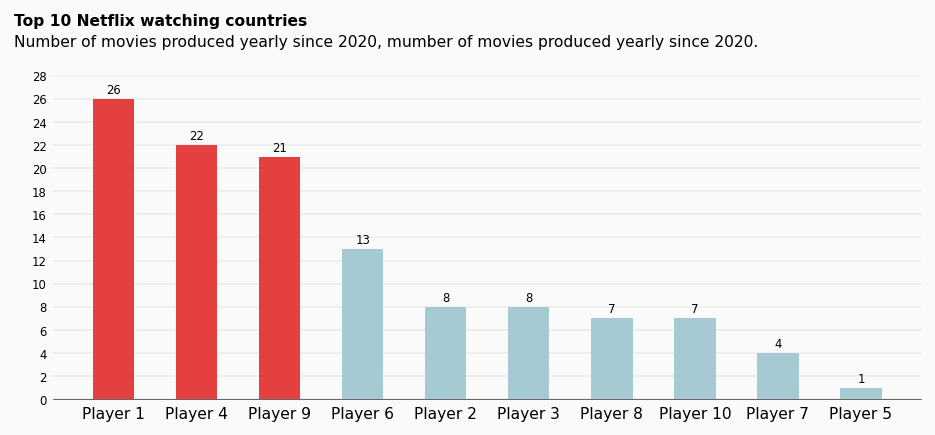

In [46]:
simple_barplot(
    goals_series,
    title='Top 10 Netflix watching countries',
    title_text='Number of movies produced yearly since 2020, mumber of movies produced yearly since 2020.'
)

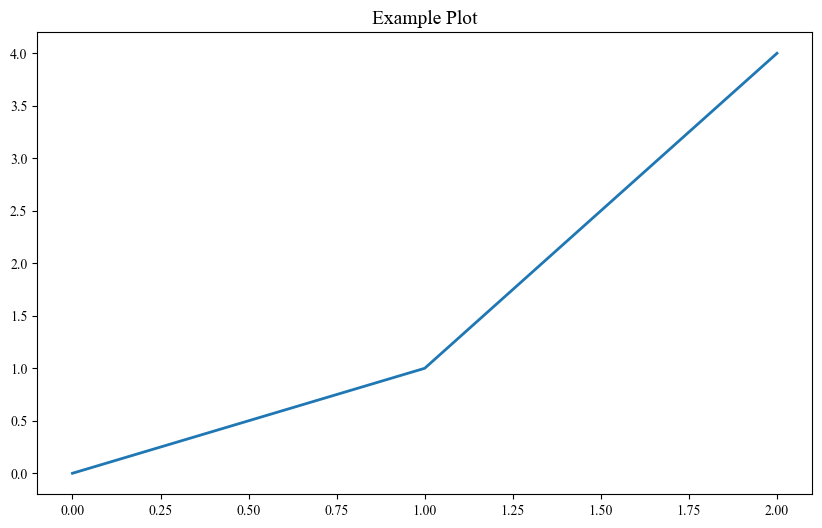

In [9]:
import matplotlib.pyplot as plt
from src.cutipy.cutipy import cutipy

cutipy()

# Now create your plots as usual
plt.plot([0, 1, 2], [0, 1, 4])
plt.title('Example Plot')
plt.show()
